In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt

In [2]:
df_cards = pd.read_csv('digimon_all_cards_details.csv')
df_prices = pd.read_csv('cardmarket_priceguide_for_ml.csv')

In [3]:
df_cards.head(5)

,name,type,id,level,play_cost,evolution_cost,evolution_color,evolution_level,xros_req,color,...,artist,main_effect,source_effect,alt_effect,series,pretty_url,date_added,tcgplayer_name,tcgplayer_id,set_name
0,A Blazing Storm of Metal!,Option,BT5-103,NaN,1.0,NaN,NaN,NaN,NaN,Black,...,NaN,[Main] Until the end of your opponent's next t...,Security Effect [Security] Your opponent's Dig...,NaN,Digimon Card Game,a-blazing-storm-of-metal-bt5-103,2024-05-27 15:14:30,A Blazing Storm of Metal!,245181.0,['BT-05: Booster Battle Of Omni']
1,A Delicate Plan,Option,BT3-097,NaN,1.0,NaN,NaN,NaN,NaN,Red,...,NaN,"[Main] 1 of your Digimon gains ""[Security] eff...",Security Effect [Security] Add this card to th...,NaN,Digimon Card Game,a-delicate-plan-bt3-097,2024-05-27 15:14:30,A Delicate Plan,231742.0,"['BT-03: Booster Union Impact', 'BT01-03: Rele..."
2,A New World,Option,P-021,NaN,0.0,NaN,NaN,NaN,NaN,Green,...,NaN,"[Main] If you have [Mimi Tachikawa] in play, y...",Security Effect [Security] Add this card to th...,NaN,Digimon Card Game,a-new-world-p-021,2024-05-27 15:14:30,A New World (Special Release Memorial Pack),234543.0,['Special Release Memorial Pack']
3,Abbadomon,Digimon,EX9-055,6.0,11.0,3.0,NaN,NaN,Assembly Requirements [Assembly -6] 4 [Negamon...,Black,...,NaN,[On Play] [When Digivolving] If there are 4 or...,NaN,Assembly Requirements [Assembly -6] 4 [Negamon...,Digimon Card Game,abbadomon-ex9-055,2025-06-05 18:02:38,Abbadomon,635491.0,['EX-09: Extra Booster Versus Monsters']
4,Abbadomon Core,Digimon,EX9-057,7.0,15.0,5.0,NaN,NaN,[Digivolve] [Abbadomon]: Cost 4,Black,...,NaN,[Breeding] [Opponent's Turn] When one of your ...,NaN,[Digivolve] [Abbadomon]: Cost 4,Digimon Card Game,abbadomon-core-ex9-057,2025-06-05 18:02:31,Abbadomon Core,635492.0,['EX-09: Extra Booster Versus Monsters']


In [4]:
df_prices.head(5)

,idProduct,idCategory,avg,low,trend,avg1,avg7,avg30
0,620001,1611,0.17,0.02,0.19,0.25,0.18,0.16
1,620002,1611,0.09,0.02,0.07,0.16,0.09,0.09
2,620003,1611,0.10,0.04,0.24,0.25,0.20,0.30
3,620004,1611,0.06,0.02,0.02,0.13,0.04,0.08
4,620005,1611,0.06,0.02,0.04,0.08,0.04,0.07


In [5]:
import pandas as pd

# =========================
# 1. Cargar datasets
# =========================

cards_path = "digimon_all_cards_details.csv"
singles_path = "products_singles_17.csv"
prices_path = "cardmarket_priceguide_for_ml.csv"

cards = pd.read_csv(cards_path)
singles = pd.read_csv(singles_path)
prices = pd.read_csv(prices_path)

print("Cartas (digimon):", cards.shape)
print("Singles (Cardmarket):", singles.shape)
print("Price guide:", prices.shape)

# =========================
# 2. Extraer el código BT/EX/etc. de 'name' en singles
#    Ejemplo: "Yokomon (BT1-001)" -> "BT1-001"
# =========================

singles["code"] = singles["name"].str.extract(r"\(([^)]+)\)")

print("Ejemplo de name -> code:")
print(singles[["name", "code"]].head())

# Comprobar porcentaje de productos con código detectado
pct_con_codigo = 1 - singles["code"].isna().mean()
print(f"% productos con code extraído: {pct_con_codigo:.2%}")

# =========================
# 3. Quitar duplicados por 'code'
#    Si una misma carta está en varias expansiones/promos, nos quedamos con UNA
#    Estrategia: ordenar por dateAdded y conservar la primera
# =========================

# Asegurar que 'dateAdded' es datetime
singles["dateAdded"] = pd.to_datetime(singles["dateAdded"], errors="coerce")

# Ordenar y eliminar duplicados por 'code'
singles_dedup = (
    singles
    .sort_values("dateAdded")
    .drop_duplicates(subset="code", keep="first")
)

print("Singles deduplicado por code:", singles_dedup.shape)

# =========================
# 4. Merge cartas (digimon) + singles (Cardmarket) usando id <-> code
# =========================

merged_cards = cards.merge(
    singles_dedup[["idProduct", "name", "code", "idExpansion", "idMetacard"]],
    left_on="id",   # columna de código en tu dataset de Digimon
    right_on="code",
    how="left"
)

print("Cartas + idProduct:", merged_cards.shape)
print("Porcentaje de cartas con idProduct:", merged_cards["idProduct"].notna().mean())

# =========================
# 5. Merge con price guide (por idProduct)
# =========================

full = merged_cards.merge(
    prices,
    on="idProduct",
    how="left"
)

print("Dataset final (cartas + precios):", full.shape)
print("Porcentaje de cartas con precio (trend no nulo):", full["trend"].notna().mean())

# =========================
# 6. Guardar dataset final para ML
# =========================

output_path = "digimon_cards_with_prices_full.csv"
full.to_csv(output_path, index=False)
print("Guardado:", output_path)


Cartas (digimon): (3841, 28)
Singles (Cardmarket): (7857, 7)
Price guide: (8189, 8)
Ejemplo de name -> code:
                  name     code
0    Yokomon (BT1-001)  BT1-001
1  Bebydomon (BT1-002)  BT1-002
2     Upamon (BT1-003)  BT1-003
3   Wanyamon (BT1-004)  BT1-004
4   Kyaromon (BT1-005)  BT1-005
% productos con code extraído: 99.97%
Singles deduplicado por code: (3725, 8)
Cartas + idProduct: (3841, 33)
Porcentaje de cartas con idProduct: 0.9671960426972143
Dataset final (cartas + precios): (3841, 40)
Porcentaje de cartas con precio (trend no nulo): 0.957823483467847
Guardado: digimon_cards_with_prices_full.csv


In [6]:
df_full = pd.read_csv('digimon_cards_with_prices_full.csv')

In [7]:
df_full.head(3)

,name_x,type,id,level,play_cost,evolution_cost,evolution_color,evolution_level,xros_req,color,...,code,idExpansion,idMetacard,idCategory,avg,low,trend,avg1,avg7,avg30
0,A Blazing Storm of Metal!,Option,BT5-103,NaN,1.0,NaN,NaN,NaN,NaN,Black,...,BT5-103,4991.0,405558.0,1611.0,1.39,0.29,1.33,1.42,1.23,0.54
1,A Delicate Plan,Option,BT3-097,NaN,1.0,NaN,NaN,NaN,NaN,Red,...,BT3-097,4986.0,405325.0,1611.0,0.04,0.02,0.24,0.04,0.05,0.27
2,A New World,Option,P-021,NaN,0.0,NaN,NaN,NaN,NaN,Green,...,P-021,4996.0,405887.0,1611.0,0.53,0.30,0.44,0.41,0.63,0.86


In [8]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3841 entries, 0 to 3840
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name_x           3841 non-null   object 
 1   type             3841 non-null   object 
 2   id               3841 non-null   object 
 3   level            3063 non-null   float64
 4   play_cost        3619 non-null   float64
 5   evolution_cost   2769 non-null   float64
 6   evolution_color  1213 non-null   object 
 7   evolution_level  923 non-null    float64
 8   xros_req         1031 non-null   object 
 9   color            3841 non-null   object 
 10  color2           748 non-null    object 
 11  digi_type        3305 non-null   object 
 12  digi_type2       1027 non-null   object 
 13  form             1073 non-null   object 
 14  dp               2868 non-null   float64
 15  attribute        2855 non-null   object 
 16  rarity           3841 non-null   object 
 17  stage         

Aquí iniciamos el trabajo en limpieza de datos del CSV para el posterior modelo de entrenamiento.

In [9]:
df = pd.read_csv("digimon_cards_with_prices_full.csv")

df.shape, df.columns

((3841, 40),
 Index(['name_x', 'type', 'id', 'level', 'play_cost', 'evolution_cost',
        'evolution_color', 'evolution_level', 'xros_req', 'color', 'color2',
        'digi_type', 'digi_type2', 'form', 'dp', 'attribute', 'rarity', 'stage',
        'artist', 'main_effect', 'source_effect', 'alt_effect', 'series',
        'pretty_url', 'date_added', 'tcgplayer_name', 'tcgplayer_id',
        'set_name', 'idProduct', 'name_y', 'code', 'idExpansion', 'idMetacard',
        'idCategory', 'avg', 'low', 'trend', 'avg1', 'avg7', 'avg30'],
       dtype='object'))

In [10]:
price_cols = ['avg', 'low', 'trend', 'avg1', 'avg7', 'avg30']

# Convertimos a numérico por si hubiera strings raros
for c in price_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Nos quedamos solo con filas donde avg no es NaN
df = df[df['avg'].notna()].copy()

df.shape


(3634, 40)

In [11]:
df['avg_log'] = np.log1p(df['avg'])


In [12]:
cols_to_drop = [
    # Metadatos e IDs externos
    'artist',
    'series',
    'pretty_url',
    'tcgplayer_name',
    'tcgplayer_id',
    'idProduct',
    'name_y',
    'code',
    'idExpansion',
    'idMetacard',
    'idCategory',

    # Evitamos usar otros precios como features por ahora (potencial leakage)
    'low', 'trend', 'avg1', 'avg7', 'avg30'
]

# Nos quedamos solo con las columnas que existan (por seguridad)
cols_to_drop = [c for c in cols_to_drop if c in df.columns]

df = df.drop(columns=cols_to_drop)

df.columns


Index(['name_x', 'type', 'id', 'level', 'play_cost', 'evolution_cost',
       'evolution_color', 'evolution_level', 'xros_req', 'color', 'color2',
       'digi_type', 'digi_type2', 'form', 'dp', 'attribute', 'rarity', 'stage',
       'main_effect', 'source_effect', 'alt_effect', 'date_added', 'set_name',
       'avg', 'avg_log'],
      dtype='object')

In [13]:
# Pasamos todo a mayúsculas
df['rarity'] = df['rarity'].str.upper()

# Aseguramos un conjunto limpio de rarezas
df['rarity'] = df['rarity'].replace({
    'C': 'C',
    'U': 'U',
    'R': 'R',
    'SR': 'SR',
    'SEC': 'SEC',
    'P': 'P',
    'UNKNOWN': 'UNKNOWN'
})

# Cualquier valor raro/nulo lo mandamos a UNKNOWN
df['rarity'] = df['rarity'].fillna('UNKNOWN')


In [14]:
df['attribute'] = df['attribute'].replace({
    'Free}}': 'Free',
    'NO DATA': 'Unknown'
})

df['attribute'] = df['attribute'].fillna('Unknown')


In [15]:
def get_first_set(x):
    if pd.isna(x):
        return np.nan
    try:
        lst = ast.literal_eval(x)
        if isinstance(lst, list) and len(lst) > 0:
            return lst[0]
    except Exception:
        # Si falla el parseo, devolvemos el valor original
        return x

df['set_name'] = df['set_name'].apply(get_first_set)
df['set_name'] = df['set_name'].fillna('Unknown')


In [16]:
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

# Si quieres, puedes quedarte solo con la fecha como tal (sin hora)
df['date_added'] = df['date_added'].dt.date


In [17]:
num_cols = ['level', 'play_cost', 'evolution_cost', 'evolution_level', 'dp']

for col in num_cols:
    df[col + '_was_missing'] = df[col].isna().astype(int)
    df[col] = df[col].fillna(0)


In [18]:
cat_cols = [
    'name_x',
    'type',
    'evolution_color',
    'xros_req',
    'color',
    'color2',
    'digi_type',
    'digi_type2',
    'form',
    'stage',
    'main_effect',
    'source_effect',
    'alt_effect',
    'set_name'
]

for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3634 entries, 0 to 3840
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name_x                       3634 non-null   object 
 1   type                         3634 non-null   object 
 2   id                           3634 non-null   object 
 3   level                        3634 non-null   float64
 4   play_cost                    3634 non-null   float64
 5   evolution_cost               3634 non-null   float64
 6   evolution_color              3634 non-null   object 
 7   evolution_level              3634 non-null   float64
 8   xros_req                     3634 non-null   object 
 9   color                        3634 non-null   object 
 10  color2                       3634 non-null   object 
 11  digi_type                    3634 non-null   object 
 12  digi_type2                   3634 non-null   object 
 13  form                   

<Axes: >

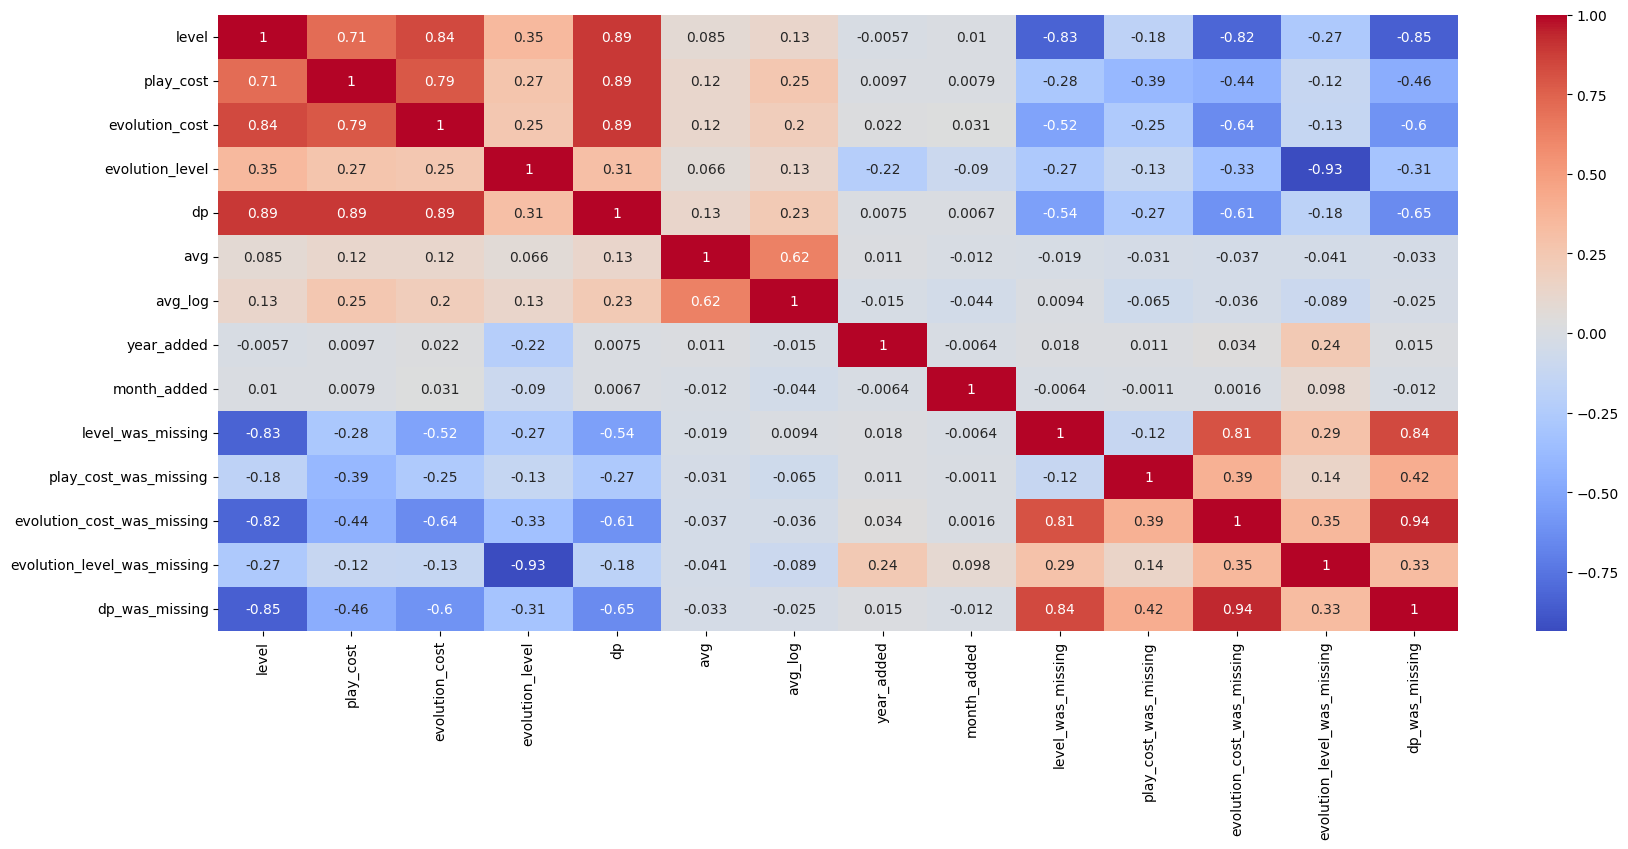

In [20]:
plt.figure(figsize = (20, 8))
sns.heatmap(df.corr(numeric_only = True), annot = True, cmap = 'coolwarm')

<Axes: ylabel='Count'>

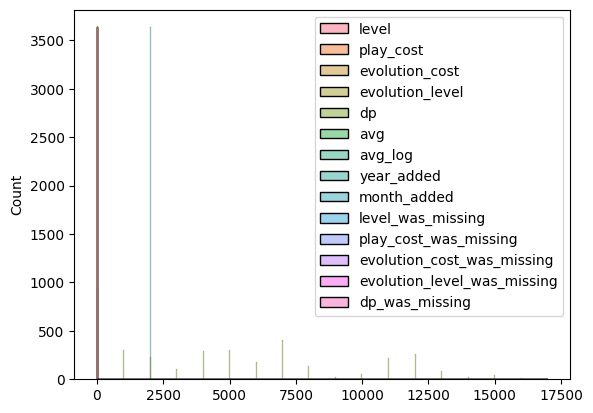

In [21]:
sns.histplot(df)

<Axes: ylabel='avg'>

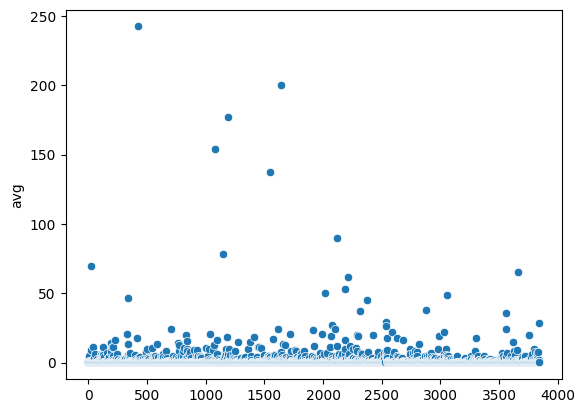

In [22]:
sns.scatterplot(df['avg'])

<Axes: ylabel='avg'>

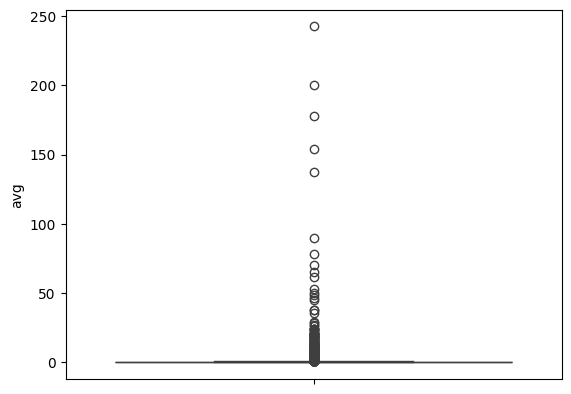

In [23]:
sns.boxplot(df['avg'])

<Axes: xlabel='rarity', ylabel='avg'>

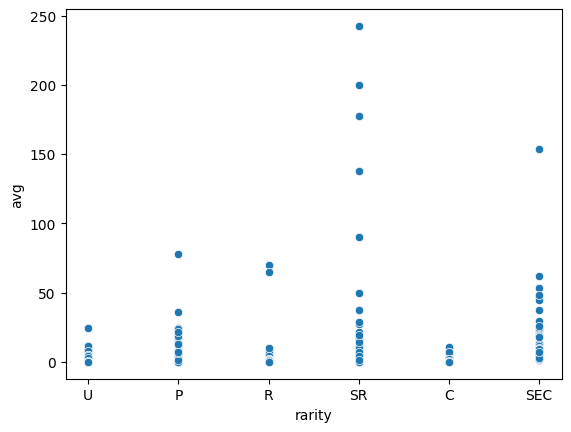

In [24]:
sns.scatterplot(y=df['avg'], x=df['rarity'])

Aquí iniciamos el entrenamiento del primer modelo baseline. Random Forest Regressor

In [25]:
target_col = 'avg_log'

X = df.drop(columns=[target_col, 'avg'])
y = df[target_col]

X.shape, y.shape


((3634, 30), (3634,))

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape


((2907, 30), (727, 30))

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Identificamos columnas categóricas y numéricas automáticamente
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

cat_cols, num_cols[:10]  # solo para echar un vistazo rápido


(['name_x',
  'type',
  'id',
  'evolution_color',
  'xros_req',
  'color',
  'color2',
  'digi_type',
  'digi_type2',
  'form',
  'attribute',
  'rarity',
  'stage',
  'main_effect',
  'source_effect',
  'alt_effect',
  'date_added',
  'set_name'],
 ['level',
  'play_cost',
  'evolution_cost',
  'evolution_level',
  'dp',
  'year_added',
  'month_added',
  'level_was_missing',
  'play_cost_was_missing',
  'evolution_cost_was_missing'])

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ],
    remainder='passthrough'  # deja las numéricas tal cual
)


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    max_depth=None,      # dejamos que crezca y luego ya tunearemos
    min_samples_leaf=1
)

model_rf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', rf)
])


In [30]:
model_rf.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicciones en escala log
y_pred_log = model_rf.predict(X_test)

# Métricas en escala log
mae_log = mean_absolute_error(y_test, y_pred_log)

# Tu versión de sklearn no soporta squared=False, así que hacemos la raíz a mano
mse_log = mean_squared_error(y_test, y_pred_log)
rmse_log = np.sqrt(mse_log)

r2_log = r2_score(y_test, y_pred_log)

print("=== Métricas en escala log(avg) ===")
print(f"MAE (log):  {mae_log:.4f}")
print(f"RMSE (log): {rmse_log:.4f}")
print(f"R² (log):   {r2_log:.4f}")

# Pasamos a escala de precio real
y_test_price = np.expm1(y_test)
y_pred_price = np.expm1(y_pred_log)

mae_price = mean_absolute_error(y_test_price, y_pred_price)

mse_price = mean_squared_error(y_test_price, y_pred_price)
rmse_price = np.sqrt(mse_price)

r2_price = r2_score(y_test_price, y_pred_price)

print("\n=== Métricas en precio real (avg) ===")
print(f"MAE (€):    {mae_price:.4f}")
print(f"RMSE (€):   {rmse_price:.4f}")
print(f"R² precio:  {r2_price:.4f}")


=== Métricas en escala log(avg) ===
MAE (log):  0.1790
RMSE (log): 0.3760
R² (log):   0.5681

=== Métricas en precio real (avg) ===
MAE (€):    0.6085
RMSE (€):   2.3974
R² precio:  0.4404


In [32]:
import numpy as np
import pandas as pd

# Obtenemos el RandomForest ya entrenado
rf_trained = model_rf.named_steps['model']

# Obtenemos el OneHotEncoder entrenado
ohe = model_rf.named_steps['preprocess'].named_transformers_['cat']

# Nombres de features categóricas tras one-hot
ohe_features = ohe.get_feature_names_out(cat_cols)

# Nombres de las numéricas (passthrough, en el mismo orden que num_cols)
num_features = np.array(num_cols)

# Concatenamos todos los nombres (primero las categóricas codificadas, luego numéricas)
all_features = np.concatenate([ohe_features, num_features])

importances = rf_trained.feature_importances_

# Creamos un DataFrame ordenado por importancia
feat_imp = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values('importance', ascending=False)

# Mostramos las 30 más importantes
feat_imp.head(30)


,feature,importance
5137,rarity_SEC,0.169280
5138,rarity_SR,0.166116
5135,rarity_P,0.075861
9280,"set_name_['BT-12: Booster Across Time', 'Ultim...",0.016408
9289,"set_name_['BT-14: Booster Blast Ace', 'BT-15: ...",0.015078
5134,rarity_C,0.013407
9199,set_name_['BT-04: Booster Great Legend'],0.011075
9409,"set_name_['Limited Card Set ONLINE 2023', 'Lim...",0.010409
9053,date_added_2025-06-13,0.010388
7924,source_effect_Unknown,0.009464


Vemos algunas columnas problemáticas por lo que procedemos a limpiar un poco más los datos para evitar el overfitting.

In [33]:
X2 = X.copy()

# Quitamos id porque es una "matrícula" de carta, puro sobreajuste
if 'id' in X2.columns:
    X2 = X2.drop(columns=['id'])

# Quitamos date_added como categórica, nos quedamos con year/month
if 'date_added' in X2.columns:
    X2 = X2.drop(columns=['date_added'])

X2.shape


(3634, 28)

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X2, y,
    test_size=0.2,
    random_state=42
)

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ],
    remainder='passthrough'
)

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    max_depth=None,
    min_samples_leaf=1
)

model_rf_v2 = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', rf)
])

model_rf_v2.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [36]:
y_pred_log = model_rf_v2.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_log = mean_absolute_error(y_test, y_pred_log)
mse_log = mean_squared_error(y_test, y_pred_log)
rmse_log = np.sqrt(mse_log)
r2_log = r2_score(y_test, y_pred_log)

print("=== RF v2 Escala log(avg) ===")
print(f"MAE (log):  {mae_log:.4f}")
print(f"RMSE (log): {rmse_log:.4f}")
print(f"R² (log):   {r2_log:.4f}")

y_test_price = np.expm1(y_test)
y_pred_price = np.expm1(y_pred_log)

mae_price = mean_absolute_error(y_test_price, y_pred_price)
mse_price = mean_squared_error(y_test_price, y_pred_price)
rmse_price = np.sqrt(mse_price)
r2_price = r2_score(y_test_price, y_pred_price)

print("\n=== RF v2 Precio real (avg) ===")
print(f"MAE (€):    {mae_price:.4f}")
print(f"RMSE (€):   {rmse_price:.4f}")
print(f"R² precio:  {r2_price:.4f}")


=== RF v2 Escala log(avg) ===
MAE (log):  0.1840
RMSE (log): 0.3788
R² (log):   0.5616

=== RF v2 Precio real (avg) ===
MAE (€):    0.6240
RMSE (€):   2.4100
R² precio:  0.4345


En este punto se inicia la mejora y optimización para el modelo final.

In [37]:
#SE PRODECE A CONVERTIR LA VARIABLE RAREZA A UNA VARIABLE ORDINAL.
#VOLVEMOS A REPARTIR LOS DATOS ENTRE X E Y PARA EL MODELO TENIENDO EN CUENTA RARITY Y RARITY RANK

In [38]:
rarity_order_map = {
    'C': 0,
    'U': 1,
    'R': 2,
    'P': 3,
    'SR': 4,
    'SEC': 5
}

df['rarity_rank'] = df['rarity'].map(rarity_order_map)


In [39]:
target_col = 'avg_log'

y = df[target_col]

X = df.drop(columns=[target_col, 'avg'])  # quitamos target y avg original
X.head()


,name_x,type,id,level,play_cost,evolution_cost,evolution_color,evolution_level,xros_req,color,...,date_added,set_name,year_added,month_added,level_was_missing,play_cost_was_missing,evolution_cost_was_missing,evolution_level_was_missing,dp_was_missing,rarity_rank
0,A Blazing Storm of Metal!,Option,BT5-103,0.0,1.0,0.0,Unknown,0.0,Unknown,Black,...,2024-05-27,['BT-05: Booster Battle Of Omni'],2024,5,1,0,1,1,1,1
1,A Delicate Plan,Option,BT3-097,0.0,1.0,0.0,Unknown,0.0,Unknown,Red,...,2024-05-27,"['BT-03: Booster Union Impact', 'BT01-03: Rele...",2024,5,1,0,1,1,1,1
2,A New World,Option,P-021,0.0,0.0,0.0,Unknown,0.0,Unknown,Green,...,2024-05-27,['Special Release Memorial Pack'],2024,5,1,0,1,1,1,3
3,Abbadomon,Digimon,EX9-055,6.0,11.0,3.0,Unknown,0.0,Assembly Requirements [Assembly -6] 4 [Negamon...,Black,...,2025-06-05,['EX-09: Extra Booster Versus Monsters'],2025,6,0,0,0,1,0,2
4,Abbadomon Core,Digimon,EX9-057,7.0,15.0,5.0,Unknown,0.0,[Digivolve] [Abbadomon]: Cost 4,Black,...,2025-06-05,['EX-09: Extra Booster Versus Monsters'],2025,6,0,0,0,1,0,4


In [40]:
X2 = X.copy()

for col in ['id', 'date_added']:
    if col in X2.columns:
        X2 = X2.drop(columns=[col])

X2.head()


,name_x,type,level,play_cost,evolution_cost,evolution_color,evolution_level,xros_req,color,color2,...,alt_effect,set_name,year_added,month_added,level_was_missing,play_cost_was_missing,evolution_cost_was_missing,evolution_level_was_missing,dp_was_missing,rarity_rank
0,A Blazing Storm of Metal!,Option,0.0,1.0,0.0,Unknown,0.0,Unknown,Black,Unknown,...,Unknown,['BT-05: Booster Battle Of Omni'],2024,5,1,0,1,1,1,1
1,A Delicate Plan,Option,0.0,1.0,0.0,Unknown,0.0,Unknown,Red,Unknown,...,Unknown,"['BT-03: Booster Union Impact', 'BT01-03: Rele...",2024,5,1,0,1,1,1,1
2,A New World,Option,0.0,0.0,0.0,Unknown,0.0,Unknown,Green,Unknown,...,Unknown,['Special Release Memorial Pack'],2024,5,1,0,1,1,1,3
3,Abbadomon,Digimon,6.0,11.0,3.0,Unknown,0.0,Assembly Requirements [Assembly -6] 4 [Negamon...,Black,Unknown,...,Assembly Requirements [Assembly -6] 4 [Negamon...,['EX-09: Extra Booster Versus Monsters'],2025,6,0,0,0,1,0,2
4,Abbadomon Core,Digimon,7.0,15.0,5.0,Unknown,0.0,[Digivolve] [Abbadomon]: Cost 4,Black,Unknown,...,[Digivolve] [Abbadomon]: Cost 4,['EX-09: Extra Booster Versus Monsters'],2025,6,0,0,0,1,0,4


In [41]:
'rarity' in X2.columns, 'rarity_rank' in X2.columns


(True, True)

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X2, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape


((2907, 29), (727, 29))

In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

print("Categóricas:", cat_cols)
print("Numéricas:", num_cols[:10], "...")  # mostramos solo algunas


Categóricas: ['name_x', 'type', 'evolution_color', 'xros_req', 'color', 'color2', 'digi_type', 'digi_type2', 'form', 'attribute', 'rarity', 'stage', 'main_effect', 'source_effect', 'alt_effect', 'set_name']
Numéricas: ['level', 'play_cost', 'evolution_cost', 'evolution_level', 'dp', 'year_added', 'month_added', 'level_was_missing', 'play_cost_was_missing', 'evolution_cost_was_missing'] ...


In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ],
    remainder='passthrough'  # deja numéricas tal cual, incluyendo rarity_rank
)

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    max_depth=None,
    min_samples_leaf=1
)

model_rf_rank = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', rf)
])

model_rf_rank.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicciones en escala log
y_pred_log = model_rf_rank.predict(X_test)

# Métricas en log(avg)
mae_log = mean_absolute_error(y_test, y_pred_log)
mse_log = mean_squared_error(y_test, y_pred_log)
rmse_log = np.sqrt(mse_log)
r2_log = r2_score(y_test, y_pred_log)

print("=== RF + rarity_rank Escala log(avg) ===")
print(f"MAE (log):  {mae_log:.4f}")
print(f"RMSE (log): {rmse_log:.4f}")
print(f"R² (log):   {r2_log:.4f}")

# Volvemos a euros
y_test_price = np.expm1(y_test)
y_pred_price = np.expm1(y_pred_log)

mae_price = mean_absolute_error(y_test_price, y_pred_price)
mse_price = mean_squared_error(y_test_price, y_pred_price)
rmse_price = np.sqrt(mse_price)
r2_price = r2_score(y_test_price, y_pred_price)

print("\n=== RF + rarity_rank Precio real (avg) ===")
print(f"MAE (€):    {mae_price:.4f}")
print(f"RMSE (€):   {rmse_price:.4f}")
print(f"R² precio:  {r2_price:.4f}")


=== RF + rarity_rank Escala log(avg) ===
MAE (log):  0.1824
RMSE (log): 0.3757
R² (log):   0.5688

=== RF + rarity_rank Precio real (avg) ===
MAE (€):    0.6203
RMSE (€):   2.4099
R² precio:  0.4346


In [46]:
import numpy as np
import pandas as pd

rf_trained = model_rf_rank.named_steps['model']
ohe = model_rf_rank.named_steps['preprocess'].named_transformers_['cat']

ohe_features = ohe.get_feature_names_out(cat_cols)
num_features = np.array(num_cols)

all_features = np.concatenate([ohe_features, num_features])
importances = rf_trained.feature_importances_

feat_imp = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values('importance', ascending=False)

feat_imp.head(30)


,feature,importance
6348,rarity_rank,0.383417
2230,rarity_SEC,0.029201
6158,"set_name_['BT-12: Booster Across Time', 'Ultim...",0.018664
6167,"set_name_['BT-14: Booster Blast Ace', 'BT-15: ...",0.016601
2886,main_effect_[Hand] [Counter] ＜Blast Digivolve＞...,0.013521
2227,rarity_C,0.013376
6077,set_name_['BT-04: Booster Great Legend'],0.011171
6287,"set_name_['Limited Card Set ONLINE 2023', 'Lim...",0.010281
6022,set_name_['3rd Anniversary Survey Pack'],0.009407
6093,set_name_['BT-05: Booster Battle Of Omni'],0.008942


In [47]:
#VAMOS A APLICAR RANDOMSEARCH Y HACER TUNNING DE FEATURES


In [48]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'model__n_estimators': [200, 400, 600, 800],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 0.5, 0.75, None]  
}

In [49]:
random_search = RandomizedSearchCV(
    estimator=model_rf_rank,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)


In [50]:
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__max_depth': [None, 10, ...], 'model__max_features': ['sqrt', 0.5, ...], 'model__min_samples_leaf': [1, 2, ...], 'model__n_estimators': [200, 400, ...]}"
,n_iter,20
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [51]:
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

print("\nMejor puntuación CV (neg MAE):")
print(random_search.best_score_)


best_rf_model = random_search.best_estimator_


Mejores hiperparámetros encontrados:
{'model__n_estimators': 800, 'model__min_samples_leaf': 1, 'model__max_features': 0.5, 'model__max_depth': None}

Mejor puntuación CV (neg MAE):
-0.23201542155537014


In [52]:
y_pred_log = best_rf_model.predict(X_test)

# Escala log
mae_log = mean_absolute_error(y_test, y_pred_log)
mse_log = mean_squared_error(y_test, y_pred_log)
rmse_log = np.sqrt(mse_log)
r2_log = r2_score(y_test, y_pred_log)

print("=== RF Tunado - Escala log(avg) ===")
print(f"MAE (log):  {mae_log:.4f}")
print(f"RMSE (log): {rmse_log:.4f}")
print(f"R² (log):   {r2_log:.4f}")

# Escala euros
y_test_price = np.expm1(y_test)
y_pred_price = np.expm1(y_pred_log)

mae_price = mean_absolute_error(y_test_price, y_pred_price)
mse_price = mean_squared_error(y_test_price, y_pred_price)
rmse_price = np.sqrt(mse_price)
r2_price = r2_score(y_test_price, y_pred_price)

print("\n=== RF Tunado - Precio real (avg) ===")
print(f"MAE (€):    {mae_price:.4f}")
print(f"RMSE (€):   {rmse_price:.4f}")
print(f"R² precio:  {r2_price:.4f}")

=== RF Tunado - Escala log(avg) ===
MAE (log):  0.1834
RMSE (log): 0.3755
R² (log):   0.5692

=== RF Tunado - Precio real (avg) ===
MAE (€):    0.6240
RMSE (€):   2.4049
R² precio:  0.4369


In [53]:
#PROBAMOS CON UN MODELO DE GRADIENT BOOSTING

In [54]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

print("Categóricas:", cat_cols)
print("Numéricas (primeras):", num_cols[:10])


Categóricas: ['name_x', 'type', 'evolution_color', 'xros_req', 'color', 'color2', 'digi_type', 'digi_type2', 'form', 'attribute', 'rarity', 'stage', 'main_effect', 'source_effect', 'alt_effect', 'set_name']
Numéricas (primeras): ['level', 'play_cost', 'evolution_cost', 'evolution_level', 'dp', 'year_added', 'month_added', 'level_was_missing', 'play_cost_was_missing', 'evolution_cost_was_missing']


In [55]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

preprocessor_gb = ColumnTransformer(
    transformers=[
        # 👇 CAMBIO: sparse_output=False en lugar de sparse=False
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    ],
    remainder='passthrough'  # deja numéricas tal cual (incluyendo rarity_rank)
)


In [56]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

model_gb = Pipeline(steps=[
    ('preprocess', preprocessor_gb),
    ('model', gbr)
])


In [57]:
model_gb.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicciones en escala log(avg)
y_pred_log_gb = model_gb.predict(X_test)

mae_log_gb = mean_absolute_error(y_test, y_pred_log_gb)
mse_log_gb = mean_squared_error(y_test, y_pred_log_gb)
rmse_log_gb = np.sqrt(mse_log_gb)
r2_log_gb = r2_score(y_test, y_pred_log_gb)

print("=== Gradient Boosting - Escala log(avg) ===")
print(f"MAE (log):  {mae_log_gb:.4f}")
print(f"RMSE (log): {rmse_log_gb:.4f}")
print(f"R² (log):   {r2_log_gb:.4f}")

# Escala de precio real
y_test_price = np.expm1(y_test)
y_pred_price_gb = np.expm1(y_pred_log_gb)

mae_price_gb = mean_absolute_error(y_test_price, y_pred_price_gb)
mse_price_gb = mean_squared_error(y_test_price, y_pred_price_gb)
rmse_price_gb = np.sqrt(mse_price_gb)
r2_price_gb = r2_score(y_test_price, y_pred_price_gb)

print("\n=== Gradient Boosting - Precio real (avg) ===")
print(f"MAE (€):    {mae_price_gb:.4f}")
print(f"RMSE (€):   {rmse_price_gb:.4f}")
print(f"R² precio:  {r2_price_gb:.4f}")


=== Gradient Boosting - Escala log(avg) ===
MAE (log):  0.2199
RMSE (log): 0.3858
R² (log):   0.5454

=== Gradient Boosting - Precio real (avg) ===
MAE (€):    0.6907
RMSE (€):   2.5514
R² precio:  0.3662


In [59]:
#SE DESCARTA EL MODELO GRADIENT BOOSTING POR REPORTAR PEORES ESTADÍSTICAS QUE RANDOM FOREST.
#SE INICIAN PRUEBAS CON MODELO CATBOOST

In [60]:
import sys
import subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "catboost"])

0

In [61]:
from catboost import CatBoostRegressor, Pool

In [62]:
# y: target en log
y = df['avg_log']

# X: todas las columnas menos avg/log
X = df.drop(columns=['avg_log', 'avg'])

# Partimos de X y quitamos id y date_added como antes
X2 = X.copy()
for col in ['id', 'date_added']:
    if col in X2.columns:
        X2 = X2.drop(columns=[col])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X2, y,
    test_size=0.2,
    random_state=42
)


In [63]:
# y: target en log
y = df['avg_log']

# X: todas las columnas menos avg/log
X = df.drop(columns=['avg_log', 'avg'])

# Partimos de X y quitamos id y date_added como antes
X2 = X.copy()
for col in ['id', 'date_added']:
    if col in X2.columns:
        X2 = X2.drop(columns=[col])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X2, y,
    test_size=0.2,
    random_state=42
)


In [64]:
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

print("Categóricas:", cat_cols)
print("Numéricas (primeras):", num_cols[:10])


Categóricas: ['name_x', 'type', 'evolution_color', 'xros_req', 'color', 'color2', 'digi_type', 'digi_type2', 'form', 'attribute', 'rarity', 'stage', 'main_effect', 'source_effect', 'alt_effect', 'set_name']
Numéricas (primeras): ['level', 'play_cost', 'evolution_cost', 'evolution_level', 'dp', 'year_added', 'month_added', 'level_was_missing', 'play_cost_was_missing', 'evolution_cost_was_missing']


In [65]:
train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_cols  # le pasamos los nombres de columnas categóricas
)

valid_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_cols
)


In [66]:
model_cb = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    n_estimators=2000,
    learning_rate=0.05,
    depth=6,
    random_state=42,
    od_type='Iter',   # early stopping
    od_wait=50,
    verbose=200       # imprime info cada 200 iteraciones
)

model_cb.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True
)


0:	learn: 0.6562575	test: 0.5641782	best: 0.5641782 (0)	total: 186ms	remaining: 6m 11s
200:	learn: 0.4218312	test: 0.3827834	best: 0.3827730 (199)	total: 7.54s	remaining: 1m 7s
400:	learn: 0.3810011	test: 0.3758825	best: 0.3757311 (397)	total: 15s	remaining: 59.7s
600:	learn: 0.3511390	test: 0.3699747	best: 0.3698453 (596)	total: 22.3s	remaining: 52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3687585522
bestIteration = 656

Shrink model to first 657 iterations.


In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicciones en escala log(avg)
y_pred_log_cb = model_cb.predict(X_test)

mae_log_cb = mean_absolute_error(y_test, y_pred_log_cb)
mse_log_cb = mean_squared_error(y_test, y_pred_log_cb)
rmse_log_cb = np.sqrt(mse_log_cb)
r2_log_cb = r2_score(y_test, y_pred_log_cb)

print("=== CatBoost - Escala log(avg) ===")
print(f"MAE (log):  {mae_log_cb:.4f}")
print(f"RMSE (log): {rmse_log_cb:.4f}")
print(f"R² (log):   {r2_log_cb:.4f}")

# Pasamos a euros reales
y_test_price = np.expm1(y_test)
y_pred_price_cb = np.expm1(y_pred_log_cb)

mae_price_cb = mean_absolute_error(y_test_price, y_pred_price_cb)
mse_price_cb = mean_squared_error(y_test_price, y_pred_price_cb)
rmse_price_cb = np.sqrt(mse_price_cb)
r2_price_cb = r2_score(y_test_price, y_pred_price_cb)

print("\n=== CatBoost - Precio real (avg) ===")
print(f"MAE (€):    {mae_price_cb:.4f}")
print(f"RMSE (€):   {rmse_price_cb:.4f}")
print(f"R² precio:  {r2_price_cb:.4f}")


=== CatBoost - Escala log(avg) ===
MAE (log):  0.2199
RMSE (log): 0.3688
R² (log):   0.5846

=== CatBoost - Precio real (avg) ===
MAE (€):    0.6643
RMSE (€):   2.1759
R² precio:  0.5391


In [68]:
feature_importances = model_cb.get_feature_importance(train_pool)
features = X_train.columns

import pandas as pd

feat_imp_cb = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

feat_imp_cb.head(30)

,feature,importance
15,rarity,27.199292
20,set_name,19.073156
28,rarity_rank,7.505812
18,source_effect,6.130997
10,digi_type,5.038388
0,name_x,4.634824
8,color,3.970500
14,attribute,3.667579
9,color2,3.029226
1,type,2.721665


In [69]:
model_cb.save_model("catboost_digimon_price.cbm")


In [74]:
#ANÁLISIS DE ERRORES POR RANGOS.

In [75]:
import numpy as np
import pandas as pd

# 1. Predicciones en log y en euros
y_pred_log_cb = model_cb.predict(X_test)

y_test_price = np.expm1(y_test)          # precio real (avg)
y_pred_price_cb = np.expm1(y_pred_log_cb)  # precio predicho

# 2. DataFrame de resultados
results = X_test.copy()

results['price_real'] = y_test_price.values
results['price_pred'] = y_pred_price_cb
results['error'] = results['price_pred'] - results['price_real']
results['abs_error'] = results['error'].abs()
results['rel_error'] = results['abs_error'] / results['price_real'].replace(0, np.nan)

# Aseguramos que rarity esté dentro del results
# (si rarity estaba en X2, ya debería estar; si no, la cogemos de df original)
if 'rarity' not in results.columns:
    # Suponiendo que el índice de X_test coincide con df
    results['rarity'] = df.loc[results.index, 'rarity'].astype(str).str.upper()
else:
    results['rarity'] = results['rarity'].astype(str).str.upper()

results.head()


,name_x,type,level,play_cost,evolution_cost,evolution_color,evolution_level,xros_req,color,color2,...,play_cost_was_missing,evolution_cost_was_missing,evolution_level_was_missing,dp_was_missing,rarity_rank,price_real,price_pred,error,abs_error,rel_error
1352,Gladimon,Digimon,4.0,5.0,2.0,Unknown,0.0,Unknown,Black,Unknown,...,0,0,1,0,0,0.05,0.052369,0.002369,0.002369,0.047386
132,AncientKazemon,Digimon,6.0,13.0,5.0,Unknown,0.0,Unknown,Yellow,Unknown,...,0,0,1,0,2,0.18,0.324100,0.144100,0.144100,0.800555
876,Dinorexmon,Digimon,6.0,13.0,5.0,Red,0.0,Unknown,Red,Green,...,0,0,1,0,2,0.04,0.161517,0.121517,0.121517,3.037919
1620,Hudiemon,Digimon,4.0,7.0,5.0,Unknown,0.0,[Digivolve] Lv.3 w/[CS] trait: Cost 4 \r\n[Dig...,Green,Yellow,...,0,0,1,0,5,23.98,10.402727,-13.577273,13.577273,0.566192
3052,ShineGreymon: Burst Mode,Digimon,7.0,15.0,5.0,Unknown,0.0,[Burst Digivolve] [ShineGreymon]: By returning...,Red,Yellow,...,0,0,1,0,4,3.65,2.562748,-1.087252,1.087252,0.297877


In [76]:
# Definimos los intervalos de precio (en función del precio REAL)
bins = [0, 1, 5, 10, 20, np.inf]
labels = ['<1€', '1–5€', '5–10€', '10–20€', '>20€']

results['price_bucket'] = pd.cut(results['price_real'], bins=bins, labels=labels, right=False)

results['price_bucket'].value_counts().sort_index()


price_bucket
<1€       616
1–5€       79
5–10€      20
10–20€      8
>20€        4
Name: count, dtype: int64

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

bucket_metrics = []

for bucket in labels:
    subset = results[results['price_bucket'] == bucket]
    if len(subset) == 0:
        continue
    
    mae = mean_absolute_error(subset['price_real'], subset['price_pred'])
    rmse = np.sqrt(mean_squared_error(subset['price_real'], subset['price_pred']))  
    
    bucket_metrics.append({
        'bucket': bucket,
        'n_cartas': len(subset),
        'MAE_€': mae,
        'RMSE_€': rmse
    })

bucket_metrics_df = pd.DataFrame(bucket_metrics).sort_values('bucket')
bucket_metrics_df



,bucket,n_cartas,MAE_€,RMSE_€
3,10–20€,8,7.993830,9.406014
1,1–5€,79,1.232455,1.791395
2,5–10€,20,4.756993,5.006960
0,<1€,616,0.231196,0.441424
4,>20€,4,21.026993,21.559507


In [ ]:
rarity_metrics = []

for r in ['C', 'U', 'R', 'SR', 'SEC', 'P']:
    subset = results[results['rarity'] == r]
    if len(subset) == 0:
        continue
    
    mae = mean_absolute_error(subset['price_real'], subset['price_pred'])
    rmse = np.sqrt(mean_squared_error(subset['price_real'], subset['price_pred']))  
    rarity_metrics.append({
        'rarity': r,
        'n_cartas': len(subset),
        'MAE_€': mae,
        'RMSE_€': rmse
    })

rarity_metrics_df = pd.DataFrame(rarity_metrics).sort_values('rarity')
rarity_metrics_df


,rarity,n_cartas,MAE_€,RMSE_€
0,C,281,0.130506,0.390722
5,P,33,2.268494,4.066922
2,R,139,0.448381,0.971096
4,SEC,10,9.029814,12.280941
3,SR,72,2.157195,3.818175
1,U,192,0.330758,0.925107


In [81]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool

# Aseguramos rarity en X_train y X_test
X_train = X_train.copy()
X_test = X_test.copy()

if 'rarity' not in X_train.columns:
    X_train['rarity'] = df.loc[X_train.index, 'rarity']
    X_test['rarity'] = df.loc[X_test.index, 'rarity']

X_train['rarity'] = X_train['rarity'].astype(str).str.upper()
X_test['rarity'] = X_test['rarity'].astype(str).str.upper()

# Definimos pesos por rareza
rarity_weight_map = {
    'C': 1.0,
    'U': 1.0,
    'R': 1.0,
    'P': 2.0,
    'SR': 3.0,
    'SEC': 4.0
}

weights_train = X_train['rarity'].map(rarity_weight_map).fillna(1.0).values

# Volvemos a definir cat_cols por si ha cambiado algo
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

train_pool_w = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_cols,
    weight=weights_train
)

valid_pool_w = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_cols
)


In [82]:
model_cb_weighted = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    n_estimators=2000,
    learning_rate=0.05,
    depth=6,
    random_state=42,
    od_type='Iter',
    od_wait=50,
    verbose=200
)

model_cb_weighted.fit(
    train_pool_w,
    eval_set=valid_pool_w,
    use_best_model=True
)


0:	learn: 0.8445633	test: 0.6281038	best: 0.6281038 (0)	total: 36.6ms	remaining: 1m 13s
200:	learn: 0.4862804	test: 0.3873333	best: 0.3873110 (198)	total: 8.11s	remaining: 1m 12s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3833753939
bestIteration = 297

Shrink model to first 298 iterations.


In [83]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicciones
y_pred_log_cb_w = model_cb_weighted.predict(X_test)

# Escala log
mae_log = mean_absolute_error(y_test, y_pred_log_cb_w)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log_cb_w))
r2_log = r2_score(y_test, y_pred_log_cb_w)

print("=== CatBoost Ponderado - Escala log(avg) ===")
print(f"MAE (log):  {mae_log:.4f}")
print(f"RMSE (log): {rmse_log:.4f}")
print(f"R² (log):   {r2_log:.4f}")

# Escala euros
y_test_price = np.expm1(y_test)
y_pred_price_cb_w = np.expm1(y_pred_log_cb_w)

mae_price = mean_absolute_error(y_test_price, y_pred_price_cb_w)
rmse_price = np.sqrt(mean_squared_error(y_test_price, y_pred_price_cb_w))
r2_price = r2_score(y_test_price, y_pred_price_cb_w)

print("\n=== CatBoost Ponderado - Precio real (avg) ===")
print(f"MAE (€):    {mae_price:.4f}")
print(f"RMSE (€):   {rmse_price:.4f}")
print(f"R² precio:  {r2_price:.4f}")


=== CatBoost Ponderado - Escala log(avg) ===
MAE (log):  0.2295
RMSE (log): 0.3834
R² (log):   0.5510

=== CatBoost Ponderado - Precio real (avg) ===
MAE (€):    0.6915
RMSE (€):   2.3614
R² precio:  0.4571


In [84]:
results_w = X_test.copy()
results_w['price_real'] = y_test_price.values
results_w['price_pred'] = y_pred_price_cb_w
results_w['rarity'] = results_w['rarity'].astype(str).str.upper()
results_w['abs_error'] = (results_w['price_pred'] - results_w['price_real']).abs()

rarity_metrics_w = []

for r in ['C', 'U', 'R', 'SR', 'SEC', 'P']:
    subset = results_w[results_w['rarity'] == r]
    if len(subset) == 0:
        continue
    
    mae = mean_absolute_error(subset['price_real'], subset['price_pred'])
    rmse = np.sqrt(mean_squared_error(subset['price_real'], subset['price_pred']))
    
    rarity_metrics_w.append({
        'rarity': r,
        'n_cartas': len(subset),
        'MAE_€': mae,
        'RMSE_€': rmse
    })

rarity_metrics_w_df = pd.DataFrame(rarity_metrics_w).sort_values('rarity')
rarity_metrics_w_df


,rarity,n_cartas,MAE_€,RMSE_€
0,C,281,0.132911,0.388873
5,P,33,2.346215,4.239619
2,R,139,0.459583,0.969699
4,SEC,10,9.554174,14.083218
3,SR,72,2.256713,3.955821
1,U,192,0.344129,0.961114


In [85]:
#SE DESCARTAN LOS CAMBIOS APLICADOS.

In [86]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Target en precio real (no log)
df['avg'] = pd.to_numeric(df['avg'], errors='coerce')

y_price = df['avg']  # target en euros

# Features X2 como antes (ya deberías tenerlas; esto es por si quieres recapitular)
X = df.drop(columns=['avg_log', 'avg'])  # quitamos target en log y avg original
X2 = X.copy()

for col in ['id', 'date_added']:
    if col in X2.columns:
        X2 = X2.drop(columns=[col])

# Train/test split (si quieres reproducir el mismo que antes, usa el mismo random_state)
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X2, y_price,
    test_size=0.2,
    random_state=42
)


In [87]:
from catboost import CatBoostRegressor, Pool

# Aseguramos tipos
X_train_p = X_train_p.copy()
X_test_p = X_test_p.copy()

cat_cols = X_train_p.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train_p.select_dtypes(exclude=['object']).columns.tolist()

print("Categóricas:", cat_cols)
print("Numéricas (primeras):", num_cols[:10])

train_pool_q = Pool(
    data=X_train_p,
    label=y_train_p,
    cat_features=cat_cols
)

valid_pool_q = Pool(
    data=X_test_p,
    label=y_test_p,
    cat_features=cat_cols
)


Categóricas: ['name_x', 'type', 'evolution_color', 'xros_req', 'color', 'color2', 'digi_type', 'digi_type2', 'form', 'attribute', 'rarity', 'stage', 'main_effect', 'source_effect', 'alt_effect', 'set_name']
Numéricas (primeras): ['level', 'play_cost', 'evolution_cost', 'evolution_level', 'dp', 'year_added', 'month_added', 'level_was_missing', 'play_cost_was_missing', 'evolution_cost_was_missing']


In [88]:
model_cb_q50 = CatBoostRegressor(
    loss_function='Quantile:alpha=0.5',  # mediana
    eval_metric='RMSE',
    n_estimators=2000,
    learning_rate=0.05,
    depth=6,
    random_state=42,
    od_type='Iter',
    od_wait=50,
    verbose=200
)

model_cb_q50.fit(
    train_pool_q,
    eval_set=valid_pool_q,
    use_best_model=True
)


0:	learn: 8.9777481	test: 3.2858019	best: 3.2858019 (0)	total: 36.3ms	remaining: 1m 12s
200:	learn: 8.5222007	test: 2.5670433	best: 2.5670433 (200)	total: 8.55s	remaining: 1m 16s
400:	learn: 8.2893683	test: 2.5285837	best: 2.5284400 (394)	total: 17.3s	remaining: 1m 8s
600:	learn: 8.2351738	test: 2.5243932	best: 2.5239559 (597)	total: 25.7s	remaining: 59.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.523955909
bestIteration = 597

Shrink model to first 598 iterations.


In [89]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_q50 = model_cb_q50.predict(X_test_p)

mae_q50 = mean_absolute_error(y_test_p, y_pred_q50)
rmse_q50 = np.sqrt(mean_squared_error(y_test_p, y_pred_q50))
r2_q50 = r2_score(y_test_p, y_pred_q50)

print("=== CatBoost Quantile alpha=0.5 (precio) ===")
print(f"MAE (€):   {mae_q50:.4f}")
print(f"RMSE (€):  {rmse_q50:.4f}")
print(f"R² precio: {r2_q50:.4f}")


=== CatBoost Quantile alpha=0.5 (precio) ===
MAE (€):   0.6636
RMSE (€):  2.5240
R² precio: 0.3798


In [90]:
model_cb_q80 = CatBoostRegressor(
    loss_function='Quantile:alpha=0.8',
    eval_metric='RMSE',
    n_estimators=2000,
    learning_rate=0.05,
    depth=6,
    random_state=42,
    od_type='Iter',
    od_wait=50,
    verbose=200
)

model_cb_q80.fit(
    train_pool_q,
    eval_set=valid_pool_q,
    use_best_model=True
)

y_pred_q80 = model_cb_q80.predict(X_test_p)

mae_q80 = mean_absolute_error(y_test_p, y_pred_q80)
rmse_q80 = np.sqrt(mean_squared_error(y_test_p, y_pred_q80))
r2_q80 = r2_score(y_test_p, y_pred_q80)

print("\n=== CatBoost Quantile alpha=0.8 (precio) ===")
print(f"MAE (€):   {mae_q80:.4f}")
print(f"RMSE (€):  {rmse_q80:.4f}")
print(f"R² precio: {r2_q80:.4f}")


0:	learn: 8.8702420	test: 3.1649232	best: 3.1649232 (0)	total: 37.6ms	remaining: 1m 15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.516754737
bestIteration = 74

Shrink model to first 75 iterations.

=== CatBoost Quantile alpha=0.8 (precio) ===
MAE (€):   0.9700
RMSE (€):  2.5168
R² precio: 0.3833


In [91]:
results_q80 = X_test_p.copy()
results_q80['price_real'] = y_test_p.values
results_q80['price_pred'] = y_pred_q80

# Aseguramos rarity
if 'rarity' not in results_q80.columns:
    results_q80['rarity'] = df.loc[results_q80.index, 'rarity']

results_q80['rarity'] = results_q80['rarity'].astype(str).str.upper()

from sklearn.metrics import mean_absolute_error, mean_squared_error

rarity_metrics_q80 = []

for r in ['C', 'U', 'R', 'SR', 'SEC', 'P']:
    subset = results_q80[results_q80['rarity'] == r]
    if len(subset) == 0:
        continue
    
    mae = mean_absolute_error(subset['price_real'], subset['price_pred'])
    rmse = np.sqrt(mean_squared_error(subset['price_real'], subset['price_pred']))
    
    rarity_metrics_q80.append({
        'rarity': r,
        'n_cartas': len(subset),
        'MAE_€': mae,
        'RMSE_€': rmse
    })

rarity_metrics_q80_df = pd.DataFrame(rarity_metrics_q80).sort_values('rarity')
rarity_metrics_q80_df


,rarity,n_cartas,MAE_€,RMSE_€
0,C,281,0.123887,0.390654
5,P,33,3.877981,4.574596
2,R,139,0.720722,1.103326
4,SEC,10,10.670142,14.271554
3,SR,72,3.580202,4.550488
1,U,192,0.405031,0.953350


In [92]:
#SE DESCARTAN LOS MODELOS ACTUALES PARA PROCEDER A ENTRENAR MODELOS SEPARADOS ENTRE CARTAS CARAS Y CARTAS BARATAS.